<a href="https://colab.research.google.com/github/ubsuny/PHY386/blob/Homework2025/2025/HW/rahatalberuni/HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW5: Star Classification Using Machine Learning

How to use an autoencoder and clustering to classify stars based on brightness.

## Learning Outcomes
By the end of this homework, you will:
- Understand how to enable **GPU acceleration** in Google Colab for deep learning tasks.
- Learn the fundamentals of **Machine Learning (ML)** and its applications in astrophysics.
- Use **autoencoders** to extract compressed features from star images.
- Apply **KMeans clustering** to classify stars based on brightness and size.
- Visualize results with **matplotlib**.

## Step 0: Enabling GPU Acceleration & Introduction to Machine Learning

### How to Enable GPU Acceleration in Google Colab
To train deep learning models efficiently, we need GPU acceleration:
1. Go to **Runtime** in the top menu.
2. Click **Change runtime type**.
3. Set **Hardware Accelerator** to **GPU**.
4. Click **Save**.

To verify GPU availability, run the following command:

In [4]:
import tensorflow as tf
print("GPU available:", tf.config.list_physical_devices('GPU'))

GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Introduction to Machine Learning (ML)
Machine Learning is a field of Artificial Intelligence (AI) that enables computers to learn patterns from data without being explicitly programmed. It is widely used in astronomy to classify celestial objects, detect anomalies, and analyze vast datasets.

#### Types of Machine Learning:
1. **Supervised Learning**: The model learns from labeled data (e.g., star classification with known brightness categories).
2. **Unsupervised Learning**: The model finds patterns without predefined labels (e.g., clustering stars based on observed properties).
3. **Reinforcement Learning**: The model learns by interacting with an environment and receiving rewards.

In this notebook, we will use **unsupervised learning** with an **autoencoder** and **KMeans clustering**.

### What is an Autoencoder?
An autoencoder is a type of neural network used for unsupervised learning. It consists of:
- **Encoder**: Compresses input data into a lower-dimensional representation.
- **Bottleneck Layer**: The smallest representation of the data.
- **Decoder**: Reconstructs the original input from the compressed representation.

Autoencoders help in **dimensionality reduction** and **feature extraction** by learning compact representations of complex data.


## 1. Install Required Libraries

In [5]:
!pip install astropy scikit-learn tensorflow matplotlib numpy photutils auto-stretch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 48.9 MB/s eta 0:00:00


## 2. Load and Stretch the RGB FITS Image
We first load astronomic pictures ([FITS file format](https://en.wikipedia.org/wiki/FITS?wprov=sfti1#)) and apply a **stretching function** (logarithmic/asinh) to enhance visibility. The general problem is that in general Astrononomic pictures are stored using 32-bit integer, while your display is only able to show 8-bot integer color range. So we have to tell the computer what to do with the missing colors.

**ToDo**: Load and plot [your assiged fits file](https://github.com/ubsuny/PHY386/blob/main/2025/HW/HW5-assignment.csv) (4 points)

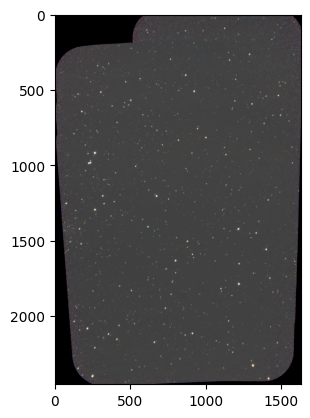

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
from auto_stretch import apply_stretch
from sklearn.cluster import KMeans
import requests
from io import BytesIO

# Replace this URL with the raw URL of your FITS file on GitHub in https://github.com/ubsuny/PHY386/tree/main/data
# Check https://github.com/ubsuny/PHY386/blob/main/2025/HW/HW5-assignment.csv for the fits file assigned to you
fits_url = "https://github.com/ubsuny/PHY386/raw/refs/heads/main/data/7.fits"

# Fetch the FITS file from the GitHub repository
response = requests.get(fits_url)
response.raise_for_status()  # Check for request errors

# Load the FITS file into an HDUList using BytesIO
hdul = fits.open(BytesIO(response.content))

# Assume the first extension contains an RGB image in (3, Height, Width) format
rgb_data = np.transpose(hdul[0].data, (1, 2, 0))  # Shape should be (3, Height, Width)
hdul.close() #

# Display the image
fig = plt.figure()
plt.imshow(apply_stretch(rgb_data))

## 3. Count Stars Using Astropy
We use **DAOStarFinder** to detect and count stars.

**ToDo**: Extract the RGB channels seperately (4 points) and find an algorithm that makes the number of the detected stars in each channel the same (4 points). Plot the combined and the three RGB channels in a 2x2 grid plot highlighting the detecting stars.(4 points)

Depending on your fits file you might have to select a part of the image for star detection.

In [7]:
# calculate the mean of the RGB channels
avg_channel = np.mean(rgb_data[:, :, :], axis=2)

def detect_stars(channel_data):
    """
    Detects stars in a 2D image using the DAOStarFinder algorithm.

    This function estimates the background statistics of the image using
    sigma-clipped statistics, then identifies star-like sources based on
    a Full Width at Half Maximum (FWHM) and a signal threshold.

    Parameters
    ----------
    channel_data : array_like
        A 2D NumPy array representing a single image channel (e.g., from a FITS image)
        where stars are to be detected. Pixel intensities should be linear (not log-scaled)
        and background-subtracted if possible.

    Returns
    -------
    astropy.table.Table
        A table of detected star sources, each with properties such as centroid
        positions, flux, sharpness, and roundness. Returns an empty table if no
        stars are found.

    Notes
    -----
    - Uses sigma-clipped statistics to robustly estimate the background mean,
      median, and standard deviation, excluding outliers like bright stars.
    - The DAOStarFinder algorithm identifies point sources based on their
      shape and brightness.
    - The detection threshold is set to 15 times the estimated background
      standard deviation, and the assumed FWHM of stars is 3 pixels.

    Examples
    --------
    >>> from astropy.io import fits
    >>> from astropy.stats import sigma_clipped_stats
    >>> from photutils.detection import DAOStarFinder
    >>> image_data = fits.getdata('example_image.fits')
    >>> stars = detect_stars(image_data)
    >>> print(len(stars))  # Number of stars detected
    """
    mean, median, std = sigma_clipped_stats(channel_data, sigma=3.0)
    finder = DAOStarFinder(fwhm=3.0, threshold=15.0*std)
    return finder(channel_data - median)


def equalize_channels(rgb_data):
    # Extract RGB channels
    r_channel, g_channel, b_channel = rgb_data[:, :, 0], rgb_data[:, :, 1], rgb_data[:, :, 2]

    # Detect and sort stars by peak brightness in each channel
    r_sources = detect_stars(r_channel)
    g_sources = detect_stars(g_channel)
    b_sources = detect_stars(b_channel)

    for sources in (r_sources, g_sources, b_sources):
        sources.sort('peak')

    # Equalize number of stars by choosing the minimum count
    min_stars = min(len(r_sources), len(g_sources), len(b_sources))

    return (
        r_sources[:min_stars],
        g_sources[:min_stars],
        b_sources[:min_stars],
        min_stars
    )

# --- Main logic ---

# Compute mean channel
avg_channel = np.mean(rgb_data, axis=2)

# Detect and sort mean channel stars once
mean_sources = detect_stars(avg_channel)
mean_sources.sort('peak')

# Equalize RGB channel stars
r_sources, g_sources, b_sources, min_stars = equalize_channels(rgb_data)
mean_sources_brightest = mean_sources[:min_stars]

# --- Output ---
print(f"Number of detected stars (average): {len(mean_sources)}")
print(f"Number of detected stars (matched to RGB count): {len(mean_sources_brightest)}")
print(f"Number of detected (red) stars: {len(r_sources)}")
print(f"Number of detected (green) stars: {len(g_sources)}")
print(f"Number of detected (blue) stars: {len(b_sources)}")

Number of detected stars (average): 1710
Number of detected stars (matched to RGB count): 1710
Number of detected (red) stars: 1881
Number of detected (green) stars: 1881
Number of detected (blue) stars: 1881


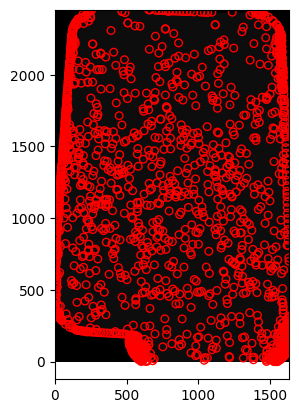

In [12]:
# Plot detected stars
plt.imshow(avg_channel, cmap='gray', origin='lower')
plt.scatter(mean_sources['xcentroid'], mean_sources['ycentroid'], s=30, edgecolor='red', facecolors='none')
plt.show()

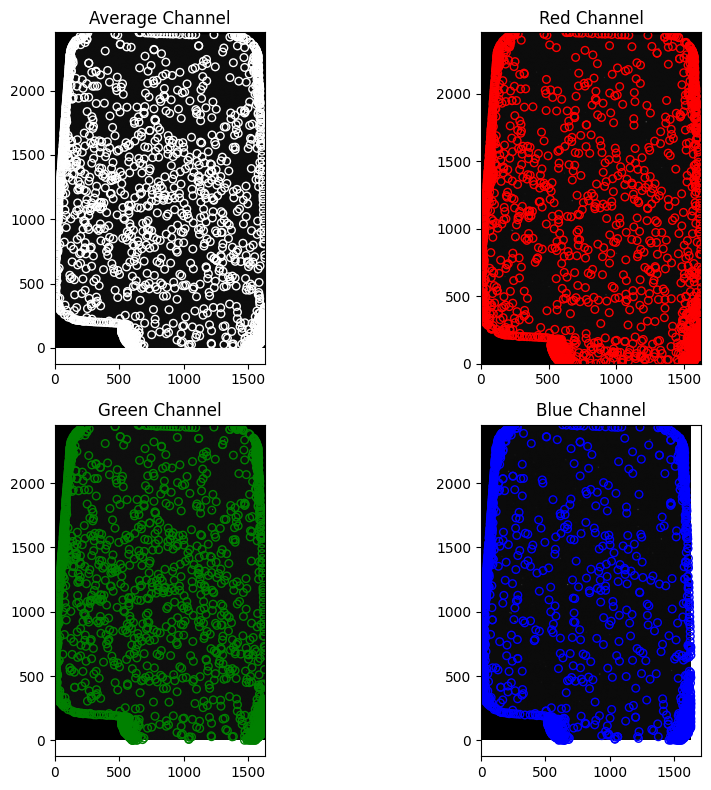

In [11]:
import matplotlib.pyplot as plt

# Create figure and subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# --- Calculate avg_sources here ---
# Extract RGB channels
red_channel, green_channel, blue_channel = rgb_data[:, :, 0], rgb_data[:, :, 1], rgb_data[:, :, 2]

# calculate the mean of the RGB channels
avg_channel = np.mean(rgb_data[:, :, :], axis=2)

# Call detect_stars function to get avg_sources
avg_sources = detect_stars(avg_channel)

# Equalize number of stars across channels
r_sources, g_sources, b_sources, min_stars = equalize_channels(rgb_data)

# --- Now proceed with plotting ---

# Plot average channel
axs[0, 0].imshow(avg_channel, cmap='gray', origin='lower')
axs[0, 0].scatter(avg_sources['xcentroid'], avg_sources['ycentroid'],
                 s=30, edgecolor='white', facecolors='none')
axs[0, 0].set_title('Average Channel')

# Plot red channel
axs[0, 1].imshow(red_channel, cmap='gray', origin='lower')
axs[0, 1].scatter(r_sources['xcentroid'], r_sources['ycentroid'],
                 s=30, edgecolor='red', facecolors='none')  # Use r_sources here
axs[0, 1].set_title('Red Channel')

# Plot green channel
axs[1, 0].imshow(green_channel, cmap='gray', origin='lower')
axs[1, 0].scatter(g_sources['xcentroid'], g_sources['ycentroid'],
                 s=30, edgecolor='green', facecolors='none')  # Use g_sources here
axs[1, 0].set_title('Green Channel')

# Plot blue channel
axs[1, 1].imshow(blue_channel, cmap='gray', origin='lower')
axs[1, 1].scatter(b_sources['xcentroid'], b_sources['ycentroid'],
                 s=30, edgecolor='blue', facecolors='none')  # Use b_sources here
axs[1, 1].set_title('Blue Channel')

# Adjust layout and display
plt.tight_layout()
plt.show()

### Step 3: Feature Extraction

**Stellar Colors and Surface Temperatures**  
Stars exhibit a variety of colors primarily because of their differing **surface temperatures**. The color of a star is directly related to its temperature: hotter stars emit more blue and ultraviolet light, while cooler stars emit more red and infrared light. This temperature dependence is explained by the concept of **blackbody radiation** and is captured in the [Planck's law](https://en.wikipedia.org/wiki/Planck%27s_law) of radiation. The [spectral classification](https://en.wikipedia.org/wiki/Stellar_classification) system categorizes stars into types (O, B, A, F, G, K, M) based on these temperatures, where O-type stars are extremely hot and blue, and M-type stars are cool and red. Understanding these differences helps astronomers not only determine the physical properties of stars but also track their evolutionary stages.

**Luminosity, Brightness, and the Hertzsprung–Russell Diagram**  
The apparent brightness of a star as seen from Earth is influenced by its intrinsic **luminosity** and its distance from the observer. Luminosity, the total energy output of a star per unit time, varies dramatically depending on the star’s mass, age, and evolutionary stage. This relationship is visualized in the [Hertzsprung–Russell diagram](https://en.wikipedia.org/wiki/Hertzsprung%E2%80%93Russell_diagram), which plots stars according to their luminosity and surface temperature. In this diagram, stars with higher luminosities can be found on the upper regions regardless of their color, indicating that a star's brightness is not solely a function of its temperature but also of its size and the stage of its [stellar evolution](https://en.wikipedia.org/wiki/Stellar_evolution). Such insights allow astronomers to predict the future behavior of stars and understand the underlying physics governing their life cycles.

**Composition, Metallicity, and Evolutionary Effects**  
Beyond temperature and mass, a star's **composition** plays a critical role in determining both its color and brightness. The abundance of elements heavier than helium—referred to as [metallicity](https://en.wikipedia.org/wiki/Metallicity)—can affect the opacity of a star's outer layers, influencing how energy is transported to the surface and thus its color and luminosity. Additionally, stars evolve over time; for example, stars in the later stages of [stellar evolution](https://en.wikipedia.org/wiki/Stellar_evolution) can swell into red giants, drastically changing their brightness and color profiles. This evolutionary process, combined with variations in initial mass and metallicity, leads to a rich diversity in the observed properties of stars. Together, these factors help astronomers piece together the history of our galaxy and the lifecycle of its stellar populations.


We extract:
- **Brightness (flux)** from each RGB channel.
- **Color Ratios**: R/G and B/G ratios to capture color differences.
- **Size Proxy** from sharpness values.
We normalize the extracted features for efficient learning.

**ToDo**: calculate the color ratios (4 points) and normalized flux ratios (4 points) for each color channel (R/G and B/G) for further analysis and generate a new `features` variable (4 points).

If you have very bright stars in your fits file you might have to use the `remove_extreme_brightness` function.

In [13]:
# Extract features (brightness and size)
flux = avg_sources['flux']
rflux = r_sources['flux']
gflux = g_sources['flux']
bflux = b_sources['flux']
# Compute size proxy
size = avg_sources['sharpness']
rsize = r_sources['sharpness']
gsize = g_sources['sharpness']
bsize = b_sources['sharpness']
# Normalize features
flux_norm = (flux - np.min(flux)) / (np.max(flux) - np.min(flux))
size_norm = (size - np.min(size)) / (np.max(size) - np.min(size))
rflux_norm = (rflux - np.min(rflux)) / (np.max(rflux) - np.min(rflux))
rsize_norm = (rsize - np.min(rsize)) / (np.max(rsize) - np.min(rsize))
gflux_norm = (gflux - np.min(gflux)) / (np.max(gflux) - np.min(gflux))
gsize_norm = (gsize - np.min(gsize)) / (np.max(gsize) - np.min(gsize))
bflux_norm = (bflux - np.min(bflux)) / (np.max(bflux) - np.min(bflux))
bsize_norm = (bsize - np.min(bsize)) / (np.max(bsize) - np.min(bsize))
features = np.vstack([flux_norm, size_norm]).T
rfeatures = np.vstack([rflux_norm, rsize_norm]).T
gfeatures = np.vstack([gflux_norm, gsize_norm]).T
bfeatures = np.vstack([bflux_norm, bsize_norm]).T

In [14]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Get star coordinates
xcentroids = avg_sources['xcentroid']
ycentroids = avg_sources['ycentroid']

# Extract color values at star locations
red = rgb_data[ycentroids.astype(int), xcentroids.astype(int), 0]  # Red channel
green = rgb_data[ycentroids.astype(int), xcentroids.astype(int), 1]  # Green channel
blue = rgb_data[ycentroids.astype(int), xcentroids.astype(int), 2]  # Blue channel

# Compute color ratios (add epsilon to avoid division by zero)
epsilon = 1e-10  # Small constant for numerical stability
red_green_ratio = (red + epsilon) / (green + epsilon)
blue_green_ratio = (blue + epsilon) / (green + epsilon)

# Normalize features using MinMax scaling
scaler = MinMaxScaler()
normalized_features = scaler.fit_transform(np.vstack([red_green_ratio, blue_green_ratio]).T)

# Extract normalized ratios
red_green_norm = normalized_features[:, 0]
blue_green_norm = normalized_features[:, 1]

# Combined feature matrix
color_features = np.vstack([red_green_norm, blue_green_norm]).T

In [15]:
def remove_extreme_brightness(star_features, brightness_threshold=3.0):
    """
    Filters out stars with exceptionally high brightness from a dataset of star features.

    This function calculates the overall brightness of each star by computing the Euclidean norm
    of its feature vector. It then determines the mean and standard deviation of these brightness
    values. Stars whose brightness exceeds the mean by more than a specified number of standard
    deviations (defined by `brightness_threshold`) are considered outliers and removed from the dataset.

    Parameters
    ----------
    star_features : ndarray
        A 2D NumPy array of shape (n_stars, n_features), where each row represents the feature vector
        of a star. It is assumed that the features are numerical and relevant to the brightness calculation.
    brightness_threshold : float, optional
        The number of standard deviations above the mean brightness to use as the cutoff for identifying
        extreme brightness values. The default is 3.0, which corresponds to the common statistical practice
        of removing data points that lie more than three standard deviations from the mean.

    Returns
    -------
    filtered_star_features : ndarray
        A 2D NumPy array containing the feature vectors of stars that are not considered extreme in brightness.
    filtered_indices : ndarray
        A 1D boolean NumPy array indicating which stars were retained (True) and which were filtered out (False).

    Notes
    -----
    - The function assumes that the Euclidean norm of the feature vectors is an appropriate measure of
      brightness. Ensure that the input features are scaled or selected accordingly.
    - This method uses a statistical approach to identify outliers based on the assumption of a normal
      distribution of brightness values. If the brightness distribution is significantly non-normal,
      consider using alternative outlier detection methods.
    - The function utilizes NumPy's `linalg.norm` to compute the Euclidean norm and `mean` and `std`
      functions to calculate statistical measures.

    Examples
    --------
    >>> import numpy as np
    >>> star_features = np.array([[1.0, 2.0], [2.0, 2.0], [10.0, 10.0]])
    >>> filtered_features, filtered_indices = remove_extreme_brightness(star_features)
    >>> filtered_features
    array([[1., 2.],
           [2., 2.]])
    >>> filtered_indices
    array([ True,  True, False])
    """

    brightness = np.linalg.norm(star_features, axis=1)  # Compute overall brightness
    mean_brightness = np.mean(brightness)
    std_brightness = np.std(brightness)
    filtered_indices = brightness < (mean_brightness + brightness_threshold * std_brightness)
    return star_features[filtered_indices], filtered_indices

## Step 4: Autoencoder for Feature Compression
An **autoencoder** is a neural network used for unsupervised learning. It learns a compact representation of input data.

### Network Architecture:
- **Input Layer**: Takes in two features (brightness and size).
- **Encoder**:
  - A hidden layer with 8 neurons extracts patterns.
  - A bottleneck layer with 2 neurons compresses the data.
- **Decoder**:
  - Expands data back to 8 neurons.
  - Outputs the reconstructed 2-feature data.

**ToDo**: Adapt the input and output shape to the new feature generated above (4 points) and use the GPU for acceleration (2 points).

Epoch 1/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.1189
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0844
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0432
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0151
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0115
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0109
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0086
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0081
Epoch 9/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0061
Epoch 10/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0044
Epoch 11/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0030
Epoch 12/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0015
Epoch 13/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014
Epoch 14/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013
Epoch 15/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - lo

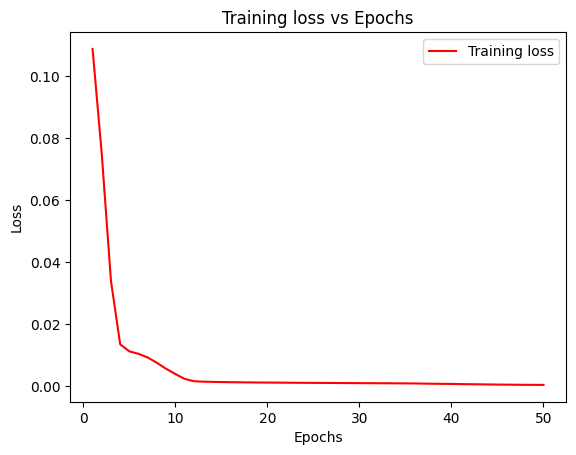

In [16]:
# Define an autoencoder model
input_layer = Input(shape=(2,))
encoded = Dense(8, activation='relu')(input_layer)
encoded = Dense(2, activation='relu')(encoded)

decoded = Dense(8, activation='relu')(encoded)
decoded = Dense(2, activation='sigmoid')(decoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train autoencoder
# Train autoencoder, store training history
history = autoencoder.fit(features, features, epochs=50, batch_size=16, verbose=1) # Assign the output of fit to history variable.
loss = history.history['loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.title('Training loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Step 5: Clustering with KMeans
After extracting compressed features, we use **KMeans clustering** to classify the stars.

In [22]:
encoder = Model(input_layer, encoded)
encoded_features = encoder.predict(features)

num_clusters = 6
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
predicted_labels = kmeans.fit_predict(encoded_features)

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


## Step 6a: Generating Synthetic Star Data
To demonstrate clustering in astrophysics, we generate synthetic stars with controlled properties.
This helps visualize how clustering can be applied to real astrophysical problems, such as distinguishing star populations.


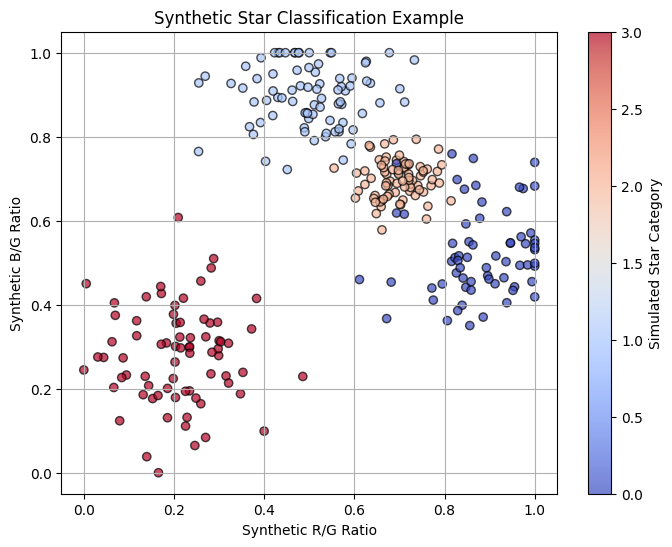

In [23]:
import random

def generate_synthetic_stars(num_stars=300):
    """Generates synthetic star data with predefined color and brightness properties."""
    categories = {
        0: {'rg': 0.9, 'bg': 0.5, 'scatter': 0.1},  # Red stars
        1: {'rg': 0.5, 'bg': 0.9, 'scatter': 0.1},  # Blue stars
        2: {'rg': 0.7, 'bg': 0.7, 'scatter': 0.05}, # White stars
        3: {'rg': 0.2, 'bg': 0.3, 'scatter': 0.1},  # Dim stars
    }

    stars = []
    labels = []

    for _ in range(num_stars):
        category = random.choice(list(categories.keys()))
        base = categories[category]
        rg = max(0, min(1, np.random.normal(base['rg'], base['scatter'])))
        bg = max(0, min(1, np.random.normal(base['bg'], base['scatter'])))
        stars.append([rg, bg])
        labels.append(category)

    return np.array(stars), np.array(labels)

# Generate and plot synthetic stars
synthetic_stars, synthetic_labels = generate_synthetic_stars()
plt.figure(figsize=(8,6))
plt.scatter(synthetic_stars[:,0], synthetic_stars[:,1], c=synthetic_labels, cmap='coolwarm', alpha=0.7, edgecolors='k')
plt.xlabel('Synthetic R/G Ratio')
plt.ylabel('Synthetic B/G Ratio')
plt.colorbar(label='Simulated Star Category')
plt.title('Synthetic Star Classification Example')
plt.grid(True)
plt.show()

## Step 6b: Visualizing real data
We plot stars with different colors representing their assigned clusters.

Clusters represent groups of stars with similar size and brightness. If clusters overlap too much, it might indicate the need for better feature separation.

**ToDo**: Generate new plots from the new clustering for the cololr ratio and size/brightness (8 points)
- **X-axis: Normalized R/G Ratio** – Represents how red the star is relative to green.
- **Y-axis: Normalized B/G Ratio** – Represents how blue the star is relative to green.
- **Point Color: Cluster Label** – Assigned cluster based on autoencoder features and KMeans.

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


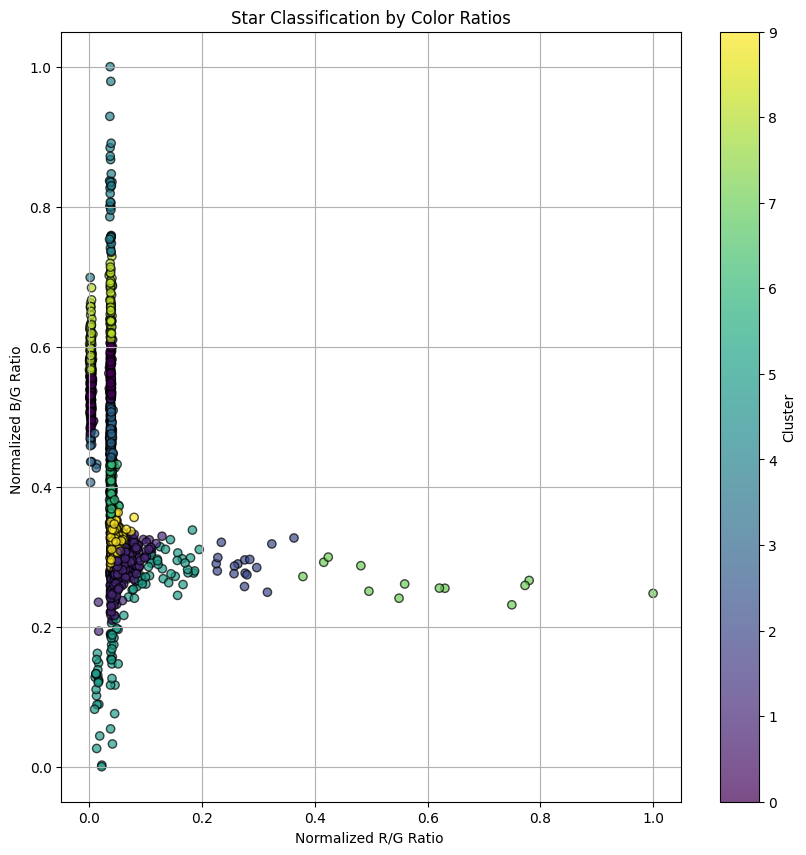

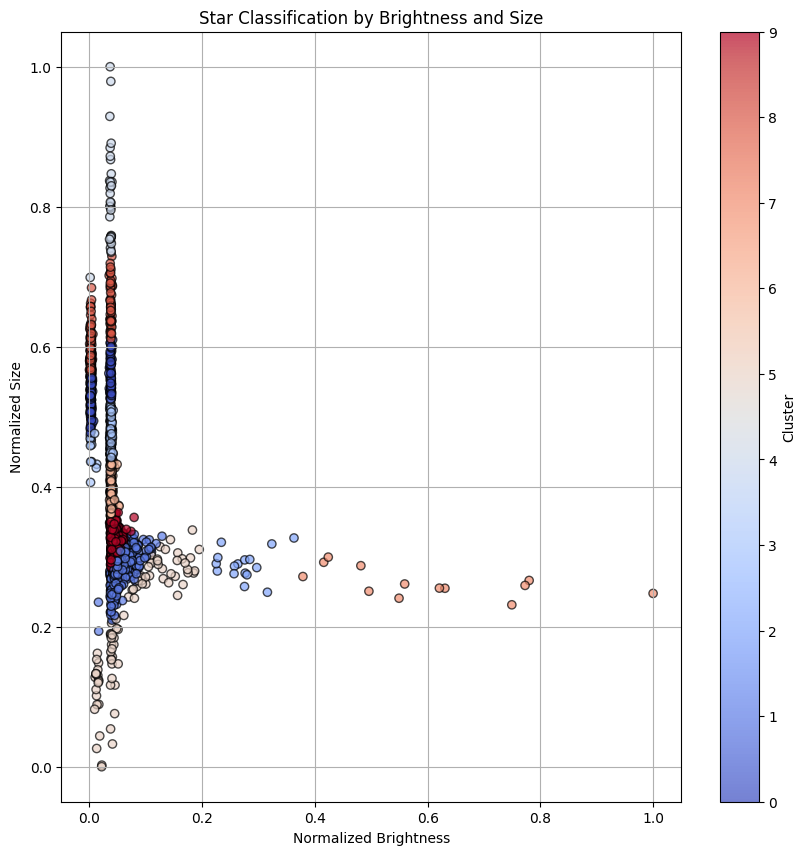

In [49]:
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer(index=2).output)
compressed_features = encoder.predict(features)

# Cluster
kmeans = KMeans(n_clusters=10, random_state=2)
predicted_labels = kmeans.fit_predict(compressed_features)

# Pull color ratios from features (columns 0 and 1)
red_green_norm = features[:, 0]
blue_green_norm = features[:, 1]

# Plot: Color Ratios (R/G vs B/G) colored by cluster
plt.figure(figsize=(10, 10))
plt.scatter(red_green_norm, blue_green_norm, c=predicted_labels, cmap='viridis', alpha=0.7, edgecolors='k')
plt.xlabel('Normalized R/G Ratio ')
plt.ylabel('Normalized B/G Ratio ')
plt.title('Star Classification by Color Ratios')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 10))
plt.scatter(features[:, 0], features[:, 1], c=predicted_labels, cmap='coolwarm', alpha=0.7, edgecolors='k')
plt.xlabel('Normalized Brightness')
plt.ylabel('Normalized Size')
plt.title('Star Classification by Brightness and Size')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()


## Step 7: Refining the Clustering
To improve clustering, we:
1. **Increase Number of Clusters** – To separate stars into more detailed groups.
2. **Use Gaussian Mixture Model (GMM)** – A probabilistic alternative to KMeans for soft clustering.

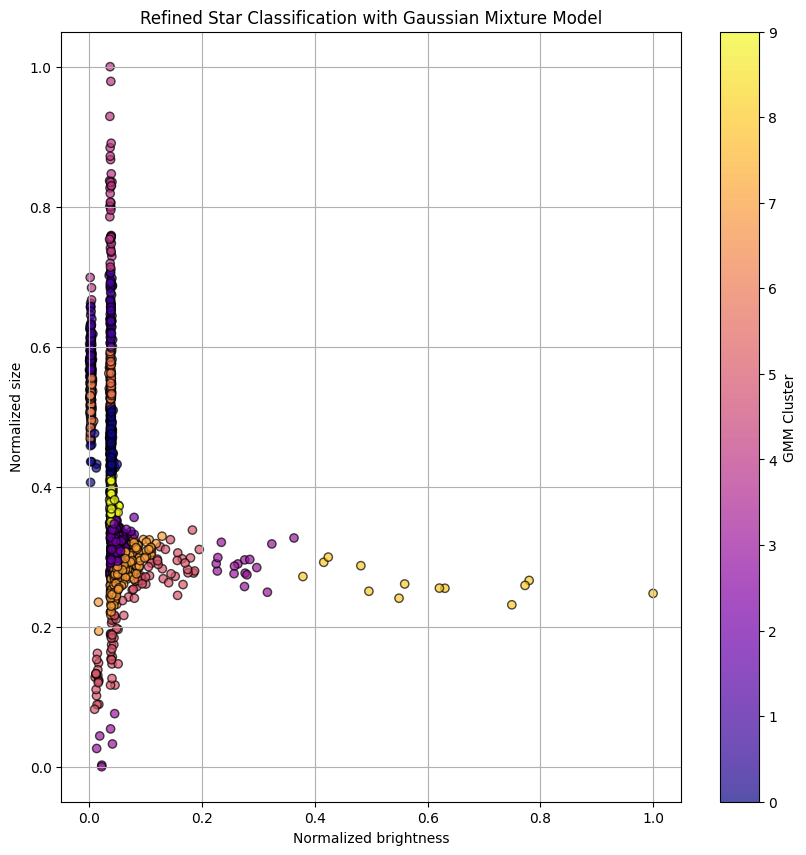

In [57]:
from sklearn.mixture import GaussianMixture

# Try different numbers of clusters
num_clusters_gmm = 10
gmm = GaussianMixture(n_components=num_clusters_gmm, random_state=42)
predicted_labels_gmm = gmm.fit_predict(encoded_features)

plt.figure(figsize=(10,10))
plt.scatter(flux_norm, size_norm, c=predicted_labels_gmm, cmap='plasma', alpha=0.7, edgecolors='k')
plt.xlabel('Normalized brightness')
plt.ylabel('Normalized size')
plt.colorbar(label='GMM Cluster')
plt.title('Refined Star Classification with Gaussian Mixture Model')
plt.grid(True)
plt.show()